# Text2Music Emotion Embedding Inference Demo
Download pretrained models ([link](https://www.dropbox.com/s/sxry48aie2r4vmt/t2m_models.tar.gz)) and required data ([link](https://www.dropbox.com/s/noezssp2vg3ud5f/t2m_data.tar.gz)).

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!wget https://www.dropbox.com/s/sxry48aie2r4vmt/t2m_models.tar.gz?dl=1
!wget https://www.dropbox.com/s/noezssp2vg3ud5f/t2m_data.tar.gz?dl=1

--2023-01-09 10:16:24--  https://www.dropbox.com/s/sxry48aie2r4vmt/t2m_models.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.84.18, 2620:100:6034:18::a27d:5412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.84.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/sxry48aie2r4vmt/t2m_models.tar.gz [following]
--2023-01-09 10:16:24--  https://www.dropbox.com/s/raw/sxry48aie2r4vmt/t2m_models.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc002057a4eaede287778153a530.dl.dropboxusercontent.com/cd/0/inline/B0PSQMGel9c2o30zS7uQlUAccK0LA3-QpN9ykBmcizk6eQfNYiFaByePwqESlq-Vw5mCRyNXqIMdKHiYqJpuW8GWyESi6O_zEEAk8vKq3mB16DYNmaZ4R1Gh5RtUtiYMPmveFJzJDYW9hDQoDtF3cpVyzVWXZXd1sjzoRRgbBt9kxw/file# [following]
--2023-01-09 10:16:24--  https://uc002057a4eaede287778153a530.dl.dropboxusercontent.com/cd/0/inline/B0PSQMGel9c2o30zS7uQlUAccK0LA3-QpN9ykBmcizk6eQfNYiFaByePwqESlq

In [2]:
!tar -xf t2m_models.tar.gz
!tar -xf t2m_data.tar.gz

In [ ]:
# install libraries 

'''
!pip install transformer
!pip install nnAudio==0.3.1
!pip install pytorch-lightning
'''

In [3]:
MODEL_PATH = './models'
DATA_PATH = './data'

In [4]:
import os
import torch
import torchaudio
import IPython
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn import metrics
from transformers import DistilBertTokenizer

from src.classification.text_classification.model import MyModel as TextCLS
from src.classification.music_classification.model import MyModel as MusicCLS
from src.regression.text_va.model import MyModel as TextVA
from src.regression.music_va.model import MyModel as MusicVA
from src.regression.text_w2v.model import MyModel as TextW2V
from src.regression.music_w2v.model import MyModel as MusicW2V
from src.metric_learning.model import MyModel as MLModel

from src.classification.music_classification.augmentations import STFT, ComplexNorm, MelScale, AmplitudeToDB, ViewAsReal

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# moods
alm_moods = ['anger', 'fearful', 'happy', 'sad', 'surprised']
isear_moods = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
audioset_moods = ['angry', 'exciting', 'funny', 'happy', 'sad', 'scary', 'tender']

# corpus
alm_corpus = np.load(os.path.join(DATA_PATH, 'text_alm_corpus.npy'), allow_pickle=True)
isear_corpus = np.load(os.path.join(DATA_PATH, 'text_isear_corpus.npy'), allow_pickle=True)

# audio preprocessing
seq = []
seq.append(STFT(n_fft=512, hop_length=256, win_length=256))
# seq.append(ViewAsReal())
seq.append(ComplexNorm(power=2.0))
seq.append(MelScale(n_mels=128, sample_rate=16000, n_stft=257))
seq.append(AmplitudeToDB())
preprocess = nn.Sequential(*seq)

# mood embeddings
mood_to_vad = pickle.load(open(os.path.join(DATA_PATH, 'tag_to_vad.pkl'), 'rb'))
alm_va = np.array([mood_to_vad[mood][:2] for mood in alm_moods])
isear_va = np.array([mood_to_vad[mood][:2] for mood in isear_moods])
audioset_va = np.array([mood_to_vad[mood][:2] for mood in audioset_moods])
word_to_vec = pickle.load(open(os.path.join(DATA_PATH, 'w2v.pkl'), 'rb'))
alm_w2v = np.array([word_to_vec[mood] for mood in alm_moods])
isear_w2v = np.array([word_to_vec[mood] for mood in isear_moods])
audioset_w2v = np.array([word_to_vec[mood] for mood in audioset_moods])

# constants
INPUT_LENGTH = 80000
NUM_CHUNKS = 4

/home/teo/.local/share/virtualenvs/text2music-emotion-embedding-j36u4T4o/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


>>> numba.__version__
'0.56.4'
>>> import librosa
>>> librosa.__version__
'0.8.1'
>>> import numpy
>>> numpy.__version__
'1.21.0'
>>> 

## Classification models
### Text classification (Alm's dataset)

In [5]:
# build a model
cls_alm = TextCLS(ndim=64, edim=512, cdim=len(alm_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_alm.load_state_dict(NS)
cls_alm = cls_alm.eval()

Downloading: 100%|██████████| 483/483 [00:00<00:00, 281kB/s]
Downloading: 100%|██████████| 268M/268M [00:32<00:00, 8.35MB/s] 
/home/teo/.local/share/virtualenvs/text2music-emotion-embedding-j36u4T4o/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [6]:
def get_alm_cls(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        text_embedding = cls_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[1][0].detach().cpu()
    return alm_moods[text_embedding.argmax()]

In [7]:
text = alm_corpus[1]
print(text)
get_alm_cls(text)

Then he got up and clambered out of the cave, went into the forest, and thought, "Here I am quite alone and deserted, how shall I obtain a horse now?"


'sad'

### Text classification (ISEAR dataset)

In [8]:
# build a model
cls_isear = TextCLS(ndim=64, edim=512, cdim=len(isear_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_isear.load_state_dict(NS)
cls_isear = cls_isear.eval()

In [9]:
def get_isear_cls(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        text_embedding = cls_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[1][0].detach().cpu()
    return isear_moods[text_embedding.argmax()]

In [10]:
text = isear_corpus[0]
print(text)
get_alm_cls(text)

During the period of falling in love, each time that we met and á especially when we had not met for a long time.


'happy'

### Music classification (Audioset mood subset)

In [11]:
import argparse

def get_parser():
  parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

  parser.add_argument('--num_workers', type=int, default=4)
  parser.add_argument('--mode', type=str, default='TRAIN', choices=['TRAIN', 'TEST'])

  # model parameters
  parser.add_argument('--ndim', type=int, default=64)
  parser.add_argument('--edim', type=int, default=64)
  parser.add_argument('--cdim', type=int, default=1)
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--num_chunk', type=int, default=16)
  parser.add_argument('--input_length', type=int, default=80000)

  # stft parameters
  parser.add_argument('--sample_rate', type=int, default=16000)
  parser.add_argument('--n_fft', type=int, default=512)
  parser.add_argument('--hop_length', type=int, default=256)
  parser.add_argument('--win_length', type=int, default=512)
  parser.add_argument('--n_bins', type=int, default=128)
  parser.add_argument('--output_type', type=str, default='spec', choices=['raw', 'spec', 'cqt'])

  # augmentation parameters
  parser.add_argument('--is_gain', type=bool, default=False)
  parser.add_argument('--gain_db_min', type=float, default=-20.0)
  parser.add_argument('--gain_db_max', type=float, default=0.0)

  parser.add_argument('--is_noise', type=bool, default=False)
  parser.add_argument('--noise_snr_min', type=float, default=40.0)
  parser.add_argument('--noise_snr_max', type=float, default=80.0)

  parser.add_argument('--is_pitch_shift', type=bool, default=False)
  parser.add_argument('--pitch_shift_margin', type=int, default=10)

  parser.add_argument('--is_noise2d', type=bool, default=False)
  parser.add_argument('--noise2d_ratio', type=float, default=0.0)

  parser.add_argument('--is_time_mask', type=bool, default=False)
  parser.add_argument('--time_mask_ratio', type=float, default=0.4)

  parser.add_argument('--is_freq_mask', type=bool, default=False)
  parser.add_argument('--freq_mask_ratio', type=int, default=0.4)

  # training parameters
  parser.add_argument('--n_epochs', type=int, default=200)
  parser.add_argument('--gpu_id', type=str, default='0')
  parser.add_argument('--lr', type=float, default=1e-4)
  parser.add_argument('--model_save_path', type=str, default='./checkpoints')
  parser.add_argument('--model_load_path', type=str, default='.')
  parser.add_argument('--data_path', type=str, default='.')
  return parser

parser = get_parser()
config = parser.parse_args(
  args=[]
)

In [12]:
from src.classification.music_classification.augmentations import get_augmentation_sequence

aug_seq, non_aug_seq = get_augmentation_sequence(config)

/home/teo/.local/share/virtualenvs/text2music-emotion-embedding-j36u4T4o/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [13]:
# import torchaudio
# y, sr = torchaudio.load('tempo_modified_accompaniment.mp3')
# y = y.mean(0)
# y = torchaudio.functional.resample(y, sr, 16000)

# hop = (len(y) - config.input_length) // config.num_chunk
# raw = torch.stack([y[i*hop:i*hop+config.input_length] for i in range(config.num_chunk)])
# # raw = np.asarray([y[i*hop:i*hop+config.input_length] for i in range(config.num_chunk)])
# spec = non_aug_seq(raw)
# spec.shape

AttributeError: module 'torchaudio.functional' has no attribute 'resample'

In [14]:
# build a model
cls_audioset = MusicCLS(ndim=64, edim=64, cdim=len(audioset_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_audioset.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_audioset.load_state_dict(NS)
cls_audioset = cls_audioset.eval()

In [15]:
def get_multichunk(wav):
    hop = (len(wav) - INPUT_LENGTH) // NUM_CHUNKS
    wav = torch.tensor([wav[i * hop : i * hop + INPUT_LENGTH] for i in range(NUM_CHUNKS)])
    return wav

def get_audioset_cls(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        song_embedding = cls_audioset.spec_to_embedding(spec)[1].detach().cpu().mean(dim=0)
    return audioset_moods[song_embedding.argmax()]

In [16]:
# wav = np.load('zzntjwL3s3g.npy')
y, sr = torchaudio.load('tempo_modified_accompaniment.mp3')
y = y.mean(0)
y = torchaudio.transforms.Resample(sr, 16000)(y)
wav = np.asarray(y)
print(get_audioset_cls(wav))
sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)



tender


/home/teo/.local/share/virtualenvs/text2music-emotion-embedding-j36u4T4o/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/teo/.local/share/virtualenvs/text2music-emotion-embedding-j36u4T4o/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # typ

## Regression models
### Text V-A regression (Alm's dataset)

In [15]:
# build a model
reg_va_alm = TextVA(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_alm.load_state_dict(NS)
reg_va_alm = reg_va_alm.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def get_alm_va(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        va = reg_va_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return va

The tailor drove quietly to church, and the princess was married to him at once, and he lived with her as happy as a woodlark.
happy


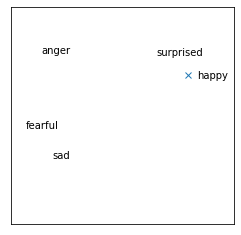

In [17]:
text = alm_corpus[15]
print(text)

va = get_alm_va(text)
dist = metrics.pairwise.euclidean_distances(alm_va, va)
print(alm_moods[dist.argmin()])

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(alm_moods):
    plt.text(alm_va[i][0], alm_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

### Text V-A regression (ISEAR dataset)

In [18]:
# build a model
reg_va_isear = TextVA(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_isear.load_state_dict(NS)
reg_va_isear = reg_va_isear.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
def get_isear_va(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        va = reg_va_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return va

When I could not remember what to say about a presentation task á at an accounts meeting.
shame


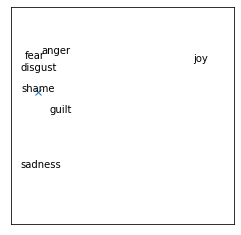

In [20]:
text = isear_corpus[12]
print(text)

va = get_isear_va(text)
dist = metrics.pairwise.euclidean_distances(isear_va, va)
print(isear_moods[dist.argmin()])

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(isear_moods):
    plt.text(isear_va[i][0], isear_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

### Music V-A regression (Audioset mood subset)

In [21]:
# build a model
reg_va_audioset = MusicVA(ndim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_music.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_audioset.load_state_dict(NS)
reg_va_audioset = reg_va_audioset.eval()

In [22]:
def get_audioset_va(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        va = reg_va_audioset.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return va

In [23]:
wav = np.load('zzntjwL3s3g.npy')
va = get_audioset_va(wav)
dist = metrics.pairwise.euclidean_distances(audioset_va, va)
print(audioset_moods[dist.argmin()])

sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(audioset_moods):
    plt.text(audioset_va[i][0], audioset_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_690753/274637415.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_690753/274637415.py'                        │
│                                                                                                  │
│ /home/teo/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:417 in load                      │
│                                                                                                  │
│    414 │   │   │   fid = file                                                                    │
│    415 │   │   │   own_fid = False                                                               │
│    416 │   │   else:                                                                             │
│ ❱  417 │   │   │   fid = stack.enter_context(open(os_fspath(file), "rb"))                        │
│    418 │   │   │   own_fid = True                                                                │
│    419 │   │                                                                                     │
│    420 │   │   # Code to distinguish from NumPy binary files and pickles.                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 'zzntjwL3s3g.npy'

### Text W2V regression (Alm's dataset)

In [171]:
# build a model
reg_w2v_alm = TextW2V(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_alm.load_state_dict(NS)
reg_w2v_alm = reg_w2v_alm.eval()

In [172]:
def get_alm_w2v(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = reg_w2v_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

In [179]:
text = alm_corpus[36]
print(text)

emb = get_alm_w2v(text)
sim = metrics.pairwise.cosine_similarity(alm_w2v, emb)
print(alm_moods[sim.argmax()])

The tailor was looking at the beauty with beating heart, when she suddenly opened her eyes, and started up at the sight of him in joyful terror.
happy


### Text W2V regression (ISEAR dataset)

In [180]:
# build a model
reg_w2v_isear = TextW2V(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_isear.load_state_dict(NS)
reg_w2v_isear = reg_w2v_isear.eval()

In [181]:
def get_isear_w2v(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = reg_w2v_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

In [182]:
text = isear_corpus[28]
print(text)

emb = get_isear_w2v(text)
sim = metrics.pairwise.cosine_similarity(isear_w2v, emb)
print(isear_moods[sim.argmax()])

When I pass an examination which I did not think I did well.
joy


### Music W2V regression (Audioset mood subset)

In [183]:
# build a model
reg_w2v_audioset = MusicW2V(ndim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_music.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_audioset.load_state_dict(NS)
reg_w2v_audioset = reg_w2v_audioset.eval()

In [184]:
def get_audioset_w2v(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        emb = reg_w2v_audioset.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return emb

In [185]:
wav = np.load('zzntjwL3s3g.npy')
emb = get_audioset_w2v(wav)
sim = metrics.pairwise.cosine_similarity(audioset_w2v, emb)
print(audioset_moods[sim.argmax()])

sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)

scary


## Metric learning models
### Three branch text-to-music (Alm's dataset - Audioset mood subset)

In [189]:
# build a model
ml_alm = MLModel()

# load state dict
S = torch.load(os.path.join(MODEL_PATH, '3b_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
ml_alm.load_state_dict(NS)
ml_alm = ml_alm.eval()

# get tag embeddings
concat_moods = list(set(['text_' + m for m in alm_moods] + ['music_' + m for m in audioset_moods]))
concat_moods.sort()
with torch.no_grad():
    mood_embs = ml_alm.tag_to_embedding(torch.tensor([word_to_vec[mood.split('_')[1]] for mood in concat_moods]))

In [190]:
def text_to_emb(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = ml_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

def wav_to_emb(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        emb = ml_alm.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return emb

In [200]:
text = alm_corpus[14]
print(text)

emb = text_to_emb(text)
sim = metrics.pairwise.cosine_similarity(mood_embs[-5:], emb)
print(concat_moods[-5:][sim.argmax()])
sim = metrics.pairwise.cosine_similarity(mood_embs[:7], emb)
print(concat_moods[:7][sim.argmax()])

The princess heard him snorting and growling; she was terrified, and she cried, "Ah, the bear is behind us and wants to get thee!"
text_fearful
music_scary


### Three branch text-to-music (ISEAR dataset - Audioset mood subset)

In [202]:
# build a model
ml_isear = MLModel()

# load state dict
S = torch.load(os.path.join(MODEL_PATH, '3b_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
ml_isear.load_state_dict(NS)
ml_isear = ml_isear.eval()

# get tag embeddings
concat_moods = list(set(['text_' + m for m in isear_moods] + ['music_' + m for m in audioset_moods]))
concat_moods.sort()
with torch.no_grad():
    mood_embs = ml_isear.tag_to_embedding(torch.tensor([word_to_vec[mood.split('_')[1]] for mood in concat_moods]))

In [203]:
def text_to_emb(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = ml_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

def wav_to_emb(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        emb = ml_isear.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return emb

In [204]:
text = isear_corpus[23]
print(text)

emb = text_to_emb(text)
sim = metrics.pairwise.cosine_similarity(mood_embs[-7:], emb)
print(concat_moods[-7:][sim.argmax()])
sim = metrics.pairwise.cosine_similarity(mood_embs[:7], emb)
print(concat_moods[:7][sim.argmax()])

When a car is overtaking another and I am forced to drive off the á road.
text_anger
music_angry
